⚠️ GPU Issue Detected? Switching to cpu for plotting.
This will be slightly slower but will guarantee generation.
Loaded Test Set: 4125 samples

Processing /content/drive/MyDrive/RoBERTa_Final_Model...


Map:   0%|          | 0/4125 [00:00<?, ? examples/s]

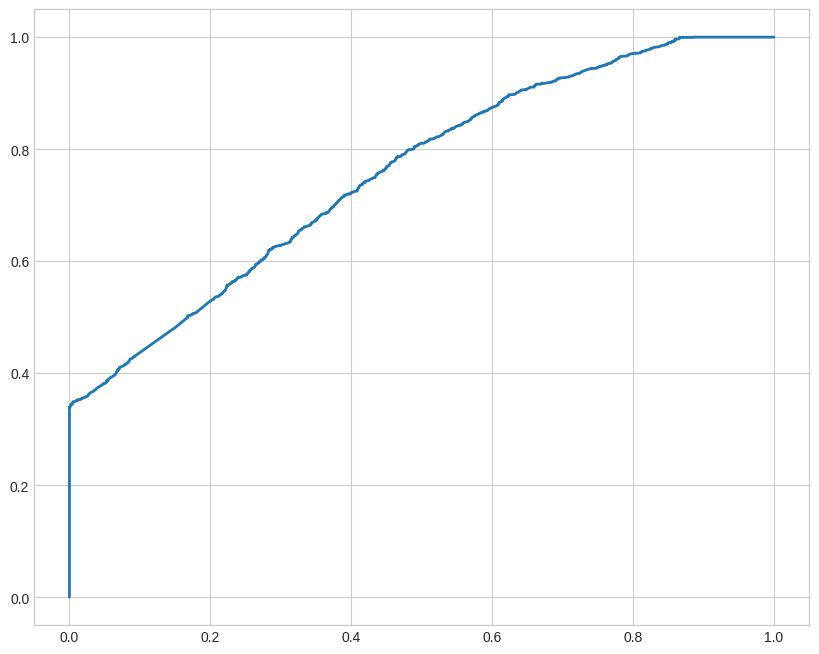

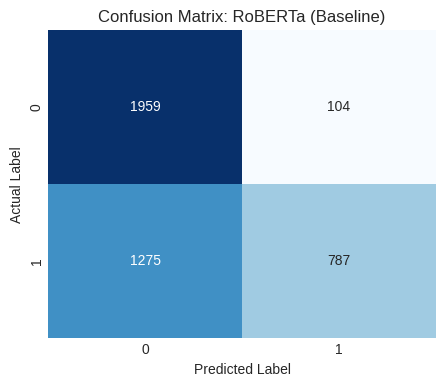


Processing /content/drive/MyDrive/DeBERTa_Standard_Model...


The tokenizer you are loading from '/content/drive/MyDrive/DeBERTa_Standard_Model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/4125 [00:00<?, ? examples/s]

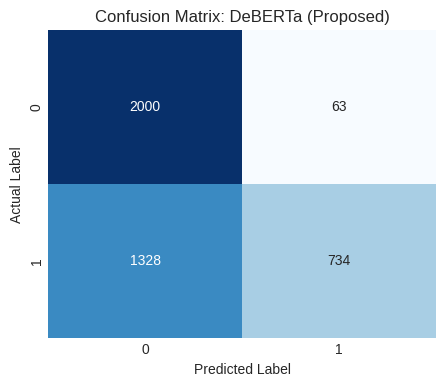


Processing /content/drive/MyDrive/DeBERTa_Augmented_Model...


The tokenizer you are loading from '/content/drive/MyDrive/DeBERTa_Augmented_Model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/4125 [00:00<?, ? examples/s]

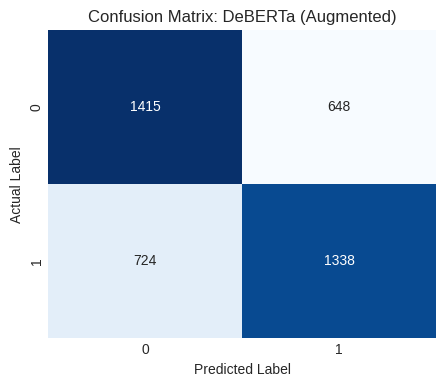

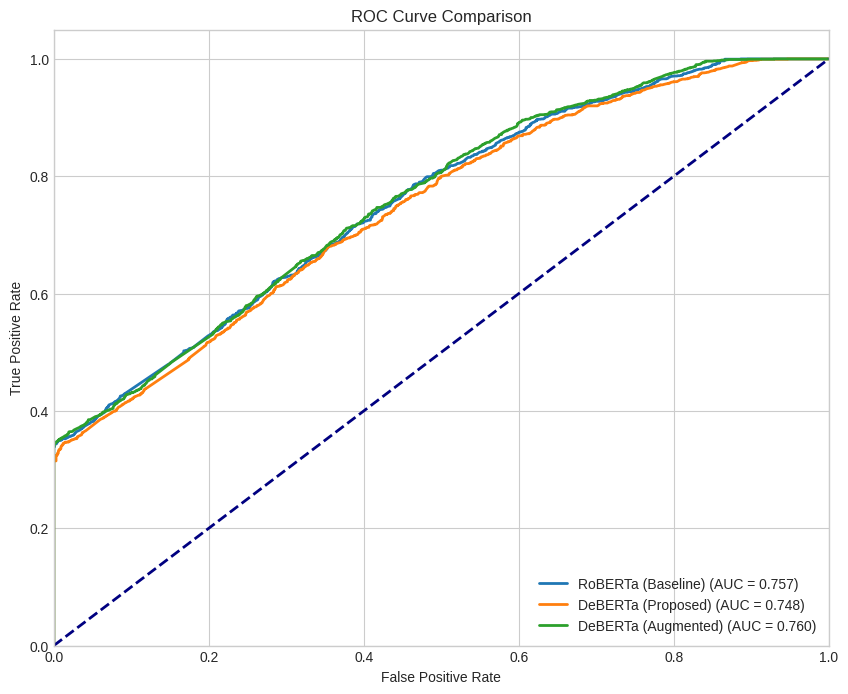


FINAL NUMBERS:
                     Accuracy       AUC
RoBERTa (Baseline)   0.665697  0.757312
DeBERTa (Proposed)   0.662788  0.747821
DeBERTa (Augmented)  0.667394  0.760278


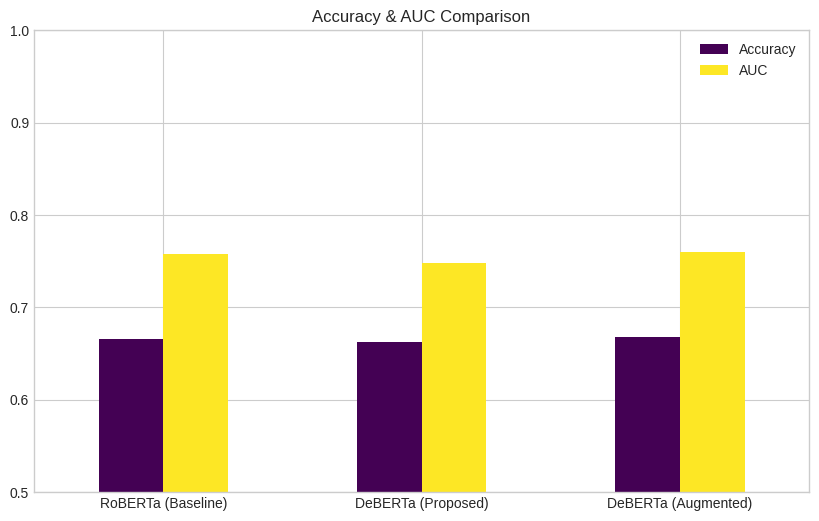

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
import torch.nn.functional as F
import os

# 1. FORCE CPU if GPU is broken
# -----------------------------------------------------
device = "cpu"
print(f"⚠️ GPU Issue Detected? Switching to {device} for plotting.")
print("This will be slightly slower but will guarantee generation.")

models_to_plot = {
    "RoBERTa (Baseline)": "/content/drive/MyDrive/RoBERTa_Final_Model",
    "DeBERTa (Proposed)": "/content/drive/MyDrive/DeBERTa_Standard_Model",
    "DeBERTa (Augmented)": "/content/drive/MyDrive/DeBERTa_Augmented_Model"
}

# 2. LOAD TEST DATA
# -----------------------------------------------------
data_path = "/content/drive/MyDrive/combined_llmfake.csv"
if not os.path.exists(data_path):
    print("Error: combined_llmfake.csv not found in Drive!")
else:
    df = pd.read_csv(data_path)
    df["label"] = df["label"].astype(int)
    from sklearn.model_selection import train_test_split
    _, test_df = train_test_split(df, test_size=0.10, stratify=df["label"], random_state=42)
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))
    print(f"Loaded Test Set: {len(test_ds)} samples")

# 3. HELPER FUNCTION
# -----------------------------------------------------
def get_predictions(model_path, dataset):
    print(f"\nProcessing {model_path}...")
    try:
        # Force CPU loading
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

        def tokenize(batch):
            return tokenizer(batch["text"], truncation=True, padding=True, max_length=512)

        dataset_tokenized = dataset.map(tokenize, batched=True)

        # Manual Inference Loop (Safer than Trainer on CPU)
        probs_list = []
        preds_list = []

        model.eval()
        with torch.no_grad():
            # Process in small batches
            batch_size = 16
            for i in range(0, len(dataset_tokenized), batch_size):
                batch = dataset_tokenized[i : i + batch_size]
                inputs = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
                preds = np.argmax(logits.cpu().numpy(), axis=-1)
                probs_list.extend(probs)
                preds_list.extend(preds)

                if i % 100 == 0: print(f"  Processed {i}/{len(dataset_tokenized)}...", end="\r")

        return np.array(probs_list), np.array(preds_list)

    except Exception as e:
        print(f"❌ Failed to load {model_path}. Reason: {e}")
        return None, None

# 4. GENERATE PLOTS
# -----------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
results = {}

for name, path in models_to_plot.items():
    if os.path.exists(path):
        probs, preds = get_predictions(path, test_ds)
        if probs is not None:
            # ROC Curve
            fpr, tpr, _ = roc_curve(test_ds["label"], probs)
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

            # Metrics
            acc = accuracy_score(test_ds["label"], preds)
            results[name] = {'Accuracy': acc, 'AUC': roc_auc}

            # Confusion Matrix
            cm = confusion_matrix(test_ds["label"], preds)
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix: {name}')
            plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
            plt.show()
    else:
        print(f"⚠️ Model folder not found: {path}")

# Finalize ROC
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve Comparison')
ax_roc.legend(loc="lower right")
# Explicitly display the figure
from IPython.display import display
display(fig_roc)

# Bar Chart
if results:
    metrics_df = pd.DataFrame(results).T
    print("\nFINAL NUMBERS:")
    print(metrics_df)

    metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title('Accuracy & AUC Comparison')
    plt.ylim(0.5, 1.0)
    plt.xticks(rotation=0)
    plt.show()